## Import Statements

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

## Device Config

In [29]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

Device : cuda


## Set the Seed for reproducibility

In [30]:
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Define number of folds

In [31]:
# Define the number of folds (k)
k = 5  # You can change this value as needed

## CNN

In [32]:
# Define your CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 10)  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Data Prep

In [33]:
# Define data augmentation and preprocessing transformations
batch_size = 20
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
augmented_train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=augmentation_transform)

# Split the dataset into k folds
fold_size = len(augmented_train_data) // k
fold_datasets = [torch.utils.data.Subset(augmented_train_data, range(i * fold_size, (i + 1) * fold_size)) for i in range(k)]

# 10 classes in total
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Test set

In [34]:
# load test data (note that the data has been transformed already)
test_images = torch.load('/kaggle/input/fall-2023-ist-557-individual-project-ii/test_image.pt')

## Training Loop

Training fold 1/5
Epoch: 1/50 	Training Loss: 1.437621 	Validation Loss: 1.231770
Epoch: 2/50 	Training Loss: 1.090271 	Validation Loss: 1.045025
Epoch: 3/50 	Training Loss: 0.930432 	Validation Loss: 1.090700
Epoch: 4/50 	Training Loss: 0.827005 	Validation Loss: 0.864227
Epoch: 5/50 	Training Loss: 0.757850 	Validation Loss: 0.796607
Epoch: 6/50 	Training Loss: 0.702467 	Validation Loss: 0.758060
Epoch: 7/50 	Training Loss: 0.655623 	Validation Loss: 0.654290
Epoch: 8/50 	Training Loss: 0.622735 	Validation Loss: 0.654307
Epoch: 9/50 	Training Loss: 0.583928 	Validation Loss: 0.628610
Epoch: 10/50 	Training Loss: 0.558751 	Validation Loss: 0.589406
Epoch: 11/50 	Training Loss: 0.528101 	Validation Loss: 0.625958
Epoch: 12/50 	Training Loss: 0.510768 	Validation Loss: 0.555056
Epoch: 13/50 	Training Loss: 0.485557 	Validation Loss: 0.538364
Epoch: 14/50 	Training Loss: 0.467585 	Validation Loss: 0.603452
Epoch: 15/50 	Training Loss: 0.453531 	Validation Loss: 0.551229
Epoch: 16/50 	Tr

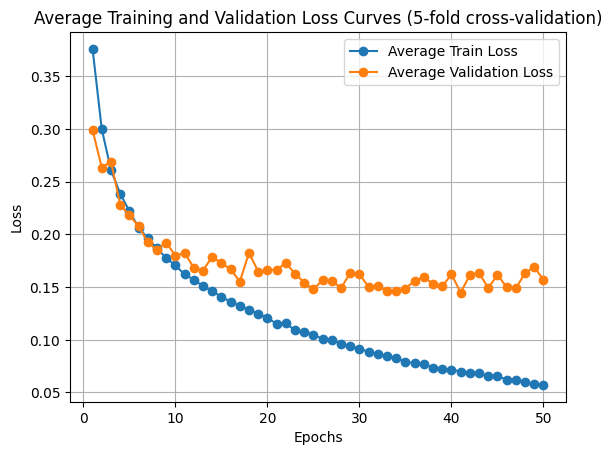

In [35]:
# Lists to store performance metrics
all_fold_train_losses = []
all_fold_val_losses = []

# Initialize your model
model = CNN()
model.to(device)

for fold_idx, fold_data in enumerate(fold_datasets):
    print(f"Training fold {fold_idx + 1}/{k}")

    # Create data loaders for training and validation
    validation_set = fold_data
    training_sets = [f for i, f in enumerate(fold_datasets) if i != fold_idx]
    training_set = torch.utils.data.ConcatDataset(training_sets)

    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)

    

    # Initialize optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Training loop
    train_losses = []
    val_losses = []
    total_epoch = 50  # You can change the number of epochs as needed

    for epoch in range(total_epoch):
        train_loss = 0.0
        valid_loss = 0.0

        # Train the model
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        # Validate the model
        model.eval()
        for valid_data, valid_target in valid_loader:
            valid_data, valid_target = valid_data.to(device), valid_target.to(device)
            valid_output = model(valid_data)
            loss = criterion(valid_output, valid_target)
            valid_loss += loss.item() * valid_data.size(0)

        avg_val_loss = valid_loss / len(validation_set)
        avg_train_loss = train_loss / len(training_set)

        val_losses.append(avg_val_loss)
        train_losses.append(avg_train_loss)

        print(f'Epoch: {epoch + 1}/{total_epoch} \tTraining Loss: {avg_train_loss:.6f} \tValidation Loss: {avg_val_loss:.6f}')

    print(f'Finished Training for fold {fold_idx + 1}/{k}')
    all_fold_train_losses.append(train_losses)
    all_fold_val_losses.append(val_losses)

# Calculate and print the average performance metrics over all folds
avg_train_losses = np.mean(all_fold_train_losses, axis=0)
avg_val_losses = np.mean(all_fold_val_losses, axis=0)

# Plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(range(1, total_epoch + 1), avg_train_losses, label='Average Train Loss', marker='o')
plt.plot(range(1, total_epoch + 1), avg_val_losses, label='Average Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Average Training and Validation Loss Curves ({k}-fold cross-validation)')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# since now we're testing (not training), we set no_grad to NOT calculate the gradients
with torch.no_grad():
    test_images = test_images.to(device)
    # calculate outputs by running images through the network
    outputs = model(test_images)
    # the class with the highest probability is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted = np.array([classes[i] for i in predicted])

submission = pd.DataFrame()
submission['label'] = predicted
submission.to_csv("kFold_50.csv", index=True, index_label='id')
submission

,label
0,cat
1,dog
2,frog
3,dog
4,truck
...,...
4995,horse
4996,ship
4997,plane
4998,dog
